### 1. Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pyodbc
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import seaborn as sns

### 2. Import data to Pandas dataframe (Kidos_Observaties and Kidos_Toestemmingen)

In [2]:
# Set to True or False depending on whether you want to import new data
NEWIMPORT = False

if NEWIMPORT:
    # Replace server name if source changes
    server = 'AZ-ODB0\ODBWB'
    database = 'OnderzoeksDB_WB'

    # Create a connection string
    connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}'

    # Establish connection
    connection = pyodbc.connect(connection_string)

    # Define columns to select
    selected_columns = ['Clientnummer',
                        'ObservatieID',
                        'ContactmomentID',
                        'Contactmomenttype', 
                        'Contactmoment_BDS_Code',
                        'Contactmoment_BDS',
                        #'cohort_nr',
                        'Cohort',
                        'Observatiedatumtijd',
                        'Observatietype_code',
                        'Observatietype',
                        'Observatie_waarde',
                        'Tweeling',
                        'Buurt_BRP',
                        'CBS_Buurtcode_BRP',
                        'UitvoerendTeam',
                        'GeboortejaarmaandBiologischeMoeder',
                        'LeeftijdBiologischeMoederBijGeboorte',
                        'Geslacht',
                        'Geboorteland',
                        'Postcode4_BRP',
                        'Postcode6_BRP',
                        'Huisnummer_BRP']

    # Define the list of included year-month combinations
    included_yearmonths = ['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012',
                           '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108', '202109', '202110', '202111', '202112']

    # Create SQL query string with specific columns and inclusion criteria
    query = f'SELECT {', '.join(selected_columns)}, Geboortejaarmaand FROM Kidos_Observaties WHERE Geboortejaarmaand IN ({', '.join(included_yearmonths)})'

    # Execute the query and fetch the data into a Pandas DataFrame
    df_observaties_og = pd.read_sql(query, connection)

    # Close the connection
    connection.close()

    # Save df_contactmomenten_og as a pickle
    df_observaties_og.to_pickle('4_Data\Pickles\observaties_zuigelingen_og.pkl')
else:
    # Load the pickle
    df_observaties_og = pd.read_pickle('4_Data\Pickles\observaties_zuigelingen_og.pkl')

In [3]:
print(f'The amount of unique \'Clientnummer\'s found in Kidos is: {len(df_observaties_og['Clientnummer'].unique())}')

The amount of unique 'Clientnummer's found in Kidos is: 8903


In [4]:
# Set to True or False depending on whether you want to import new data
NEWIMPORT = False

if NEWIMPORT:
    # Replace server name if source changes
    server = 'AZ-ODB0\ODBWB'
    database = 'OnderzoeksDB_WB'

    # Create a connection string
    connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}'

    # Establish connection
    connection = pyodbc.connect(connection_string)

    # Define columns to select
    selected_columns = ['FK_CLIENT_ID',
                        'TOESTEMMINGSVRAAG',
                        'ANTWOORD',
                        'BEGINDATUM']

    # Define a list of Clientnummers to include
    included_clientnummers = df_observaties_og['Clientnummer'].unique()
    print(len(included_clientnummers))

    # Create SQL query string with specific columns and inclusion criteria
    query = f'SELECT {', '.join(selected_columns)} FROM Kidos_TOESTEMMINGEN WHERE FK_CLIENT_ID IN ({', '.join(included_clientnummers)})'

    # Execute the query and fetch the data into a Pandas DataFrame
    df_toestemmingen_og = pd.read_sql(query, connection)

    # Close the connection
    connection.close()

    # Save df_contactmomenten_og as a pickle
    df_toestemmingen_og.to_pickle('4_Data\Pickles\\toestemmingen_zuigelingen_og.pkl')
else:
    # Load the pickle
    df_toestemmingen_og = pd.read_pickle('4_Data\Pickles\\toestemmingen_zuigelingen_og.pkl')

In [5]:
# Import municipalities to a pandas df
df_cbs = pd.read_excel('4_Data/2b-GWB2023_PC6.xlsx')

# Define list of relevant municipalities
municipalities = ['Alphen-Chaam',
                  'Altena',
                  'Baarle-Nassau',
                  'Breda',
                  'Drimmelen',
                  'Etten-Leur',
                  'Geertruidenberg',
                  'Halderberge',
                  'Oosterhout',
                  'Zundert']

# Drop 'GemCode', 'WijkCode', 'Wijknaam', 'BuurtCode', 'Buurtnaam' en 'AantalAdressen' from df_pc6
df_cbs = df_cbs.drop(columns=['GemCode', 'WijkCode', 'Wijknaam', 'BuurtCode', 'Buurtnaam', 'AantalAdressen'])

# Filter the df_pc4 to only include the relevant municipalities
df_cbs = df_cbs[df_cbs['GemNaam'].isin(municipalities)]

# Remove last two characters of 'PC6'
df_cbs['PC4'] = df_cbs['PC6'].astype(str).str[:-2]

# Drop 'PC6' from df_pc6
df_cbs = df_cbs.drop(columns='PC6')

# Drop duplicates from df_pc6
df_cbs = df_cbs.drop_duplicates()

# Define list of relevant PC4 codes for Breda
breda = ['4841',
         '4847',
         '4851',
         '4854']

# From cbs_pc4 remove all rows with 'GemNaam == Breda' and 'PC4' not in breda
df_cbs = df_cbs[~((df_cbs['GemNaam'] == 'Breda') & (~df_cbs['PC4'].isin(breda)))]

# Store unique postcodes in a list
cbs_pc4 = df_cbs['PC4']

#### 2.1 Drop clients with objection

In [6]:
# Store copy of unique records of df_og in df
df_toestemmingen = df_toestemmingen_og.drop_duplicates()

# Remove all rows where Observatie_waarde != 'Toestemming gegevensuitwisseling RVP'
toestemmingen_oz = df_toestemmingen[df_toestemmingen['TOESTEMMINGSVRAAG'] == 'Bezwaar wetenschappelijk onderzoek']

# Get most recent 'toestemmingen'
zuigelingen_toestemmingen_oz = toestemmingen_oz.groupby('FK_CLIENT_ID')['BEGINDATUM'].idxmax()

# Get all the indices (.values) from the df
most_recent = toestemmingen_oz.loc[zuigelingen_toestemmingen_oz.values]

# Select only constant variables, observaties will be added later
zuigelingen_toestemmingen = most_recent[['FK_CLIENT_ID', 'ANTWOORD']]

# Save objection zuigelingen
zuigelingen_objection = list(zuigelingen_toestemmingen[zuigelingen_toestemmingen['ANTWOORD'] == 'wel bezwaar']['FK_CLIENT_ID'])

# Get only rows from df_observaties where Clientnummer is not in zuigelingen_objection
df_observaties = df_toestemmingen[~df_toestemmingen['FK_CLIENT_ID'].isin(zuigelingen_objection)]

In [7]:
print(f'The amount of unique \'Clientnummer\'s without objection is: {len(df_observaties_og['Clientnummer'].unique())}')

The amount of unique 'Clientnummer's without objection is: 8903


#### 2.2 Get overall most-recent constant variables and relevant observation types

In [8]:
# Store copy of unique records of df_og in df
df_observaties = df_observaties_og.drop_duplicates()

In [9]:
# Sort the df by 'Observatiedatumtijd'
df_observaties = df_observaties.sort_values(by='Observatiedatumtijd', ascending=True)

##### 2.2.1 Geboortejaarmaand

In [10]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geboortejaarmaand'].transform(lambda x: x.first_valid_index() == x.index)

# Filter the DataFrame using the mask
geboortejaarmaand_overall = df_observaties.loc[mask, ['Clientnummer', 'Geboortejaarmaand']]

In [11]:
# Convert 'Geboortejaarmaand' to Month date type
geboortejaarmaand_overall['Geboortejaarmaand'] = pd.to_datetime(geboortejaarmaand_overall['Geboortejaarmaand'], format='%Y%m').dt.to_period('M')

In [12]:
geboortejaarmaand_overall.isna().mean()

Clientnummer         0.0
Geboortejaarmaand    0.0
dtype: float64

##### 2.2.2 Tweeling

In [13]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Tweeling'].transform(lambda x: x.first_valid_index() == x.index)

# Filter the DataFrame using the mask
tweeling_overall = df_observaties.loc[mask, ['Clientnummer', 'Tweeling']]

In [14]:
tweeling_overall.isna().mean()

Clientnummer    0.0
Tweeling        0.0
dtype: float64

##### 2.2.3 GeboortejaarmaandBiologischeMoeder

In [15]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['GeboortejaarmaandBiologischeMoeder'].transform(lambda x: x.first_valid_index() == x.index)

# Filter the DataFrame using the mask
geboortejaarmaand_biologischemoeder_overall = df_observaties.loc[mask, ['Clientnummer', 'GeboortejaarmaandBiologischeMoeder']]

In [16]:
# Set GeboortejaarmaandBiologischeMoeder to NaN if it is '00'
geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'].replace('00', np.NaN)

# Change month dtypes
geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'] = pd.to_datetime(geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'], format='%Y%m').dt.to_period('M')

In [17]:
geboortejaarmaand_biologischemoeder_overall.isna().mean()

Clientnummer                          0.000000
GeboortejaarmaandBiologischeMoeder    0.156239
dtype: float64

##### 2.2.4 LeeftijdBiologischeMoederBijGeboorte

In [18]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['LeeftijdBiologischeMoederBijGeboorte'].transform(lambda x: x.first_valid_index() == x.index)

# Filter the DataFrame using the mask
leeftijd_biologischemoeder_overall = df_observaties.loc[mask, ['Clientnummer', 'LeeftijdBiologischeMoederBijGeboorte']]

In [19]:
leeftijd_biologischemoeder_overall.isna().mean()

Clientnummer                            0.0
LeeftijdBiologischeMoederBijGeboorte    0.0
dtype: float64

##### 2.2.5 Geslacht

In [20]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geslacht'].transform(lambda x: x.first_valid_index() == x.index)

# Filter the DataFrame using the mask
geslacht_overall = df_observaties.loc[mask, ['Clientnummer', 'Geslacht']]

In [21]:
geslacht_overall.isna().mean()

Clientnummer    0.0
Geslacht        0.0
dtype: float64

##### 2.2.6 Geboorteland

In [22]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geboorteland'].transform(lambda x: x.first_valid_index() == x.index)

# Filter the DataFrame using the mask
geboorteland_overall = df_observaties.loc[mask, ['Clientnummer', 'Geboorteland']]

In [23]:
geboorteland_overall.isna().mean()

Clientnummer    0.0
Geboorteland    0.0
dtype: float64

##### 2.2.7 Huisnummer_BRP

In [24]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Huisnummer_BRP'].transform(lambda x: x.first_valid_index() == x.index)

# Filter the DataFrame using the mask
huisnummer_brp_overall = df_observaties.loc[mask, ['Clientnummer', 'Huisnummer_BRP']]

In [25]:
huisnummer_brp_overall.isna().mean()

Clientnummer      0.0
Huisnummer_BRP    0.0
dtype: float64

##### 2.2.8 Postcode6_BRP

In [26]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Postcode6_BRP'].transform(lambda x: x.first_valid_index() == x.index)

# Filter the DataFrame using the mask
postcode6_brp_overall = df_observaties.loc[mask, ['Clientnummer', 'Postcode6_BRP']]

In [27]:
postcode6_brp_overall.isna().mean()

Clientnummer     0.0
Postcode6_BRP    0.0
dtype: float64

### 3. Transform rows from observations to clients

#### 3.1 Show unique clients vs. df rows

In [28]:
print(f'The amount of observations in the df is: {len(df_observaties)}, the amount of unique client ID\'s is: {len(df_observaties['Clientnummer'].unique())}')

The amount of observations in the df is: 1157211, the amount of unique client ID's is: 8903


#### 3.2 Create overview of vaccinations per client ID

In [29]:
# Filter rows where 'Observatietype' is in the predefined list of relevant values
observaties_relevant = ['B.M.R.',
                        'DTP',
                        'Pneu',
                        'DKTP-Hib-Hepatitis B',
                        'DKTP',
                        'MenC',
                        'MenACWY',
                        'Hib',
                        'DKTP-Hepatitis B',
                        'DKTP-Hib']
df_observaties = df_observaties[df_observaties['Observatietype'].isin(observaties_relevant)]

In [30]:
df_observaties.shape

(48393, 23)

In [31]:
for column in df_observaties:
    print(f'\'{column}\': \'{df_observaties[column].dtype}\',')

'Clientnummer': 'object',
'ObservatieID': 'object',
'ContactmomentID': 'object',
'Contactmomenttype': 'object',
'Contactmoment_BDS_Code': 'object',
'Contactmoment_BDS': 'object',
'Cohort': 'object',
'Observatiedatumtijd': 'object',
'Observatietype_code': 'object',
'Observatietype': 'object',
'Observatie_waarde': 'object',
'Tweeling': 'object',
'Buurt_BRP': 'object',
'CBS_Buurtcode_BRP': 'object',
'UitvoerendTeam': 'object',
'GeboortejaarmaandBiologischeMoeder': 'object',
'LeeftijdBiologischeMoederBijGeboorte': 'float64',
'Geslacht': 'object',
'Geboorteland': 'object',
'Postcode4_BRP': 'object',
'Postcode6_BRP': 'object',
'Huisnummer_BRP': 'object',
'Geboortejaarmaand': 'object',


In [32]:
# List all columns to be casted
convert_dict = {
    'Clientnummer': 'object',
    'ObservatieID': 'object',
    'ContactmomentID': 'object',
    'Contactmomenttype': 'object',
    'Contactmoment_BDS_Code': 'object',
    'Contactmoment_BDS': 'object',
    'Cohort': 'object',
    'Observatiedatumtijd': 'object',
    'Observatietype_code': 'object',
    'Observatietype': 'category', # Changed
    'Observatie_waarde': 'object',
    'Tweeling': 'object',
    'Buurt_BRP': 'object',
    'CBS_Buurtcode_BRP': 'object',
    'UitvoerendTeam': 'object',
    'GeboortejaarmaandBiologischeMoeder': 'object',
    'LeeftijdBiologischeMoederBijGeboorte': 'float64',
    'Geslacht': 'object',
    'Geboorteland': 'object',
    'Geboortejaarmaand': 'object'
}

# Cast columns
df_observaties = df_observaties.astype(convert_dict)

##### 3.2.1 Exclude vaccinations that were given after cut-off ages

In [33]:
# From Observatiedatumtijd get the combination of year and month
df_observaties['Observatiedatumtijd'] = pd.to_datetime(df_observaties['Observatiedatumtijd']).dt.to_period('M')
df_observaties['Geboortejaarmaand'] = pd.to_datetime(df_observaties['Geboortejaarmaand'], format='%Y%m').dt.to_period('M')

# Calculate age at observation time in years
df_observaties['Observatie_leeftijd'] = (df_observaties['Observatiedatumtijd'] - df_observaties['Geboortejaarmaand']).apply(lambda x: x.n)

# Identify rows where birth_yearmonths is in 2012 or 2013 and age_at_observation is more than 10
over_time = df_observaties[(df_observaties['Geboortejaarmaand'].dt.year.isin([2021, 2022])) & (df_observaties['Observatie_leeftijd'] > 24)].index

# Filter rows where 'Observatietype' is in the specified list and if the row is identified in over_time
over_time_selected = over_time[df_observaties.loc[over_time, 'Observatietype'].isin(observaties_relevant)]

# Add 'Excluded' as a category to the 'Observatietype' column
df_observaties['Observatietype'] = df_observaties['Observatietype'].cat.add_categories(['Excluded'])

# Set Observatietype to 'Excluded' for rows identified in over_time_selected
df_observaties.loc[over_time_selected, 'Observatietype'] = 'Excluded'

##### 3.2.2 Transform table structure

In [34]:
# Group by 'Clientnummer' and 'Observatietype' and count the occurrences
clients_observaties_frequencies = df_observaties.groupby(['Clientnummer', 'Observatietype', 'Observatie_waarde']).size().reset_index(name='Frequency')

# Remove all rows where Observatie_waarde != 'GIVEN'
clients_observaties_frequencies = clients_observaties_frequencies[clients_observaties_frequencies['Observatie_waarde'] == 'GIVEN']

# Pivot this so every row is a unique client ID and columns are observaties, with counts as values
clients_observaties = clients_observaties_frequencies.pivot(index='Clientnummer', columns='Observatietype', values='Frequency')

# Show head
print(clients_observaties.shape)
clients_observaties.head()

(6066, 9)


Observatietype,B.M.R.,DKTP,DKTP-Hib-Hepatitis B,DTP,Hib,MenACWY,MenC,Pneu,Excluded
Clientnummer,,,,,,,,,
10072368,0,0,0,0,0,0,0,0,4
10074469,0,0,1,0,0,1,0,0,0
10078060,0,0,0,0,0,0,0,0,1
10080706,0,0,0,0,0,0,0,0,1
10081814,0,0,0,0,0,0,0,0,1


In [35]:
# Fill all NaN values with 0
clients_observaties = clients_observaties.fillna(0)

#### 3.3 Split/combine vaccinations

In [36]:
# Extract and unify individual vaccinations from combi vaccinations and add them to corresponding columns
clients_observaties['Hepatitis_B'] = clients_observaties['DKTP-Hib-Hepatitis B']
clients_observaties['DKTP'] = clients_observaties['DKTP'] + clients_observaties['DKTP-Hib-Hepatitis B']
clients_observaties['Hib'] = clients_observaties['Hib'] + clients_observaties['DKTP-Hib-Hepatitis B']

# Drop DKTP-Hib-Hepatitis B now that we extracted the individual vaccinations
clients_observaties.drop(['DKTP-Hib-Hepatitis B'], axis=1, inplace=True)

In [37]:
# Merge MenACWY and MenC into one column
clients_observaties['MenACWY/MenC'] = clients_observaties['MenACWY'] + clients_observaties['MenC']

# Drop MenACWY and MenC now that we merged them
clients_observaties.drop(['MenACWY', 'MenC'], axis=1, inplace=True)

#### 3.4 Construct client constants

##### 3.4.1 Most-recent constants in relevant observation types

In [38]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geboortejaarmaand'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboortejaarmaand = df_observaties.loc[mask, ['Clientnummer', 'Geboortejaarmaand']]

In [39]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Tweeling'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
tweeling = df_observaties.loc[mask, ['Clientnummer', 'Tweeling']]

In [40]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['GeboortejaarmaandBiologischeMoeder'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboortejaarmaand_biologischemoeder = df_observaties.loc[mask, ['Clientnummer', 'GeboortejaarmaandBiologischeMoeder']]

In [41]:
# Set GeboortejaarmaandBiologischeMoeder to NaN if it is '00'
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'].replace('00', np.NaN)

# Change month dtypes
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = pd.to_datetime(geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'], format='%Y%m').dt.to_period('M')

In [42]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['LeeftijdBiologischeMoederBijGeboorte'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
leeftijd_biologischemoeder = df_observaties.loc[mask, ['Clientnummer', 'LeeftijdBiologischeMoederBijGeboorte']]

In [43]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geslacht'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geslacht = df_observaties.loc[mask, ['Clientnummer', 'Geslacht']]

In [44]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geboorteland'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboorteland = df_observaties.loc[mask, ['Clientnummer', 'Geboorteland']]

In [45]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Huisnummer_BRP'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
huisnummer_brp = df_observaties.loc[mask, ['Clientnummer', 'Huisnummer_BRP']]

In [46]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Postcode6_BRP'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
postcode6_brp = df_observaties.loc[mask, ['Clientnummer', 'Postcode6_BRP']]

##### 3.4.2 Merge constants from 3.4.1

In [47]:
# Merge on 'Clientnummer'
clients_constants = (pd.Series(clients_observaties.index).to_frame()
                     .merge(geboortejaarmaand, on='Clientnummer', how='left')
                     .merge(tweeling, on='Clientnummer', how='left')
                     .merge(geboortejaarmaand_biologischemoeder, on='Clientnummer', how='left')
                     .merge(leeftijd_biologischemoeder, on='Clientnummer', how='left')
                     .merge(geslacht, on='Clientnummer', how='left')
                     .merge(geboorteland, on='Clientnummer', how='left')
                     .merge(huisnummer_brp, on='Clientnummer', how='left')
                     .merge(postcode6_brp, on='Clientnummer', how='left'))

In [48]:
clients_constants.isna().mean()

Clientnummer                            0.000000
Geboortejaarmaand                       0.000000
Tweeling                                0.000000
GeboortejaarmaandBiologischeMoeder      0.163699
LeeftijdBiologischeMoederBijGeboorte    0.163699
Geslacht                                0.000000
Geboorteland                            0.001813
Huisnummer_BRP                          0.008078
Postcode6_BRP                           0.008078
dtype: float64

##### 3.4.3 Overall most-recent constants

In [49]:
# Merge on 'Clientnummer'
clients_constants_overall = (pd.Series(clients_observaties.index).to_frame()
                             .merge(geboortejaarmaand_overall, on='Clientnummer', how='left')
                             .merge(tweeling_overall, on='Clientnummer', how='left')
                             .merge(geboortejaarmaand_biologischemoeder_overall, on='Clientnummer', how='left')
                             .merge(leeftijd_biologischemoeder_overall, on='Clientnummer', how='left')
                             .merge(geslacht_overall, on='Clientnummer', how='left')
                             .merge(geboorteland_overall, on='Clientnummer', how='left')
                             .merge(huisnummer_brp_overall, on='Clientnummer', how='left')
                             .merge(postcode6_brp_overall, on='Clientnummer', how='left'))

In [50]:
clients_constants_overall.isna().mean()

Clientnummer                            0.000000
Geboortejaarmaand                       0.000000
Tweeling                                0.000000
GeboortejaarmaandBiologischeMoeder      0.163699
LeeftijdBiologischeMoederBijGeboorte    0.163699
Geslacht                                0.000000
Geboorteland                            0.001813
Huisnummer_BRP                          0.002143
Postcode6_BRP                           0.002143
dtype: float64

##### 3.4.4 Fill NA's with constants from 3.4.3

In [51]:
# Fill missings in clients_constants with clients_constants_overall
for column in clients_constants.columns:
    if column != 'Clientnummer':
        clients_constants[column] = clients_constants[column].fillna(clients_constants_overall[column])

In [52]:
clients_constants.isna().mean()

Clientnummer                            0.000000
Geboortejaarmaand                       0.000000
Tweeling                                0.000000
GeboortejaarmaandBiologischeMoeder      0.163699
LeeftijdBiologischeMoederBijGeboorte    0.163699
Geslacht                                0.000000
Geboorteland                            0.001813
Huisnummer_BRP                          0.002143
Postcode6_BRP                           0.002143
dtype: float64

##### 3.4.5 Set appropriate dtypes

In [53]:
def boolean_mapper(df_observaties):
    # Define function to preprocess boolean-like values for casting
    def convert_to_bool(column):
        bool_mapping = {'Ja': True, 'Nee': False}
        return bool_mapping.get(column, np.NaN)

    # List all columns to be casted
    columns_to_convert = ['Tweeling']

    # Cast columns
    for col in columns_to_convert:
        df_observaties[col] = df_observaties[col].apply(convert_to_bool)
    return df_observaties

# Map boolean-like values to True's and False's
clients_constants = boolean_mapper(clients_constants)

In [54]:
clients_constants

,Clientnummer,Geboortejaarmaand,Tweeling,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland,Huisnummer_BRP,Postcode6_BRP
0,10072368,2021-02,False,NaT,NaN,Vrouwelijk,Syrië,20,4811RT
1,10074469,2020-01,False,NaT,NaN,Mannelijk,Syrië,220,4876BH
2,10078060,2021-10,False,NaT,NaN,Mannelijk,Spanje,21,4944WB
3,10080706,2021-06,False,1995-01,26.0,Vrouwelijk,Syrië,28,5131GA
4,10081814,2021-08,False,NaT,NaN,Vrouwelijk,Oekraïne,26,4811DG
...,...,...,...,...,...,...,...,...,...
6061,9654881,2020-04,False,1992-10,27.0,Vrouwelijk,Libanon,58,4741BE
6062,9663525,2020-04,False,1989-10,30.0,Mannelijk,Groot-Brittannië,67,4834VJ
6063,9666666,2021-02,False,2003-01,18.0,Vrouwelijk,Syrië,49,4754AM
6064,9753124,2020-01,False,1985-11,34.0,Mannelijk,Syrië,8,4624RB


In [55]:
# List all columns to be casted
convert_dict = {'Clientnummer': 'object',
                'Geboortejaarmaand': 'object',
                'Tweeling': 'boolean', # Changed
                'GeboortejaarmaandBiologischeMoeder': 'object',
                'LeeftijdBiologischeMoederBijGeboorte': 'float64',
                'Geslacht': 'category', # Changed
                'Geboorteland': 'category'} # Changed

# Cast columns
clients_constants = clients_constants.astype(convert_dict)

#### 3.5 Merge constants and vaccinations

In [56]:
# This is where the observaties are added
df_observaties = clients_observaties.merge(clients_constants, on='Clientnummer', how='left')

In [57]:
df_observaties.isna().mean()

Clientnummer                            0.000000
B.M.R.                                  0.000000
DKTP                                    0.000000
DTP                                     0.000000
Hib                                     0.000000
Pneu                                    0.000000
Excluded                                0.000000
Hepatitis_B                             0.000000
MenACWY/MenC                            0.000000
Geboortejaarmaand                       0.000000
Tweeling                                0.000000
GeboortejaarmaandBiologischeMoeder      0.163699
LeeftijdBiologischeMoederBijGeboorte    0.163699
Geslacht                                0.000000
Geboorteland                            0.001813
Huisnummer_BRP                          0.002143
Postcode6_BRP                           0.002143
dtype: float64

In [58]:
# Show head
print(df_observaties.shape)
df_observaties.head()

(6066, 17)


,Clientnummer,B.M.R.,DKTP,DTP,Hib,Pneu,Excluded,Hepatitis_B,MenACWY/MenC,Geboortejaarmaand,Tweeling,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland,Huisnummer_BRP,Postcode6_BRP
0,10072368,0,0,0,0,0,4,0,0,2021-02,False,NaT,NaN,Vrouwelijk,Syrië,20,4811RT
1,10074469,0,1,0,1,0,0,1,1,2020-01,False,NaT,NaN,Mannelijk,Syrië,220,4876BH
2,10078060,0,0,0,0,0,1,0,0,2021-10,False,NaT,NaN,Mannelijk,Spanje,21,4944WB
3,10080706,0,0,0,0,0,1,0,0,2021-06,False,1995-01,26.0,Vrouwelijk,Syrië,28,5131GA
4,10081814,0,0,0,0,0,1,0,0,2021-08,False,NaT,NaN,Vrouwelijk,Oekraïne,26,4811DG


### 4. Exclude zuigelingen outside of specified region

In [59]:
# Specify relevant region
pc4_to_include = list(cbs_pc4)
pc6_to_exclude = ['4851CM']

#### 4.1 Import Client ID's and merge with Clientnummers

In [60]:
# Set to True or False depending on whether you want to import new data
NEWIMPORT = False

if NEWIMPORT:
    # Replace server name if source changes
    server = 'AZ-ODB0\ODBWB'
    database = 'OnderzoeksDB_WB'

    # Create a connection string
    connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}'

    # Establish connection
    connection = pyodbc.connect(connection_string)

    # Create list from all unique values in df_observaties['Clientnummer']
    clientnummers = df_observaties['Clientnummer'].unique()

    # Create SQL query string with specific columns and inclusion criteria
    query = f'SELECT ID, CLIENTNUMMER FROM Kidos_CLIENTEN WHERE CLIENTNUMMER IN ({', '.join(clientnummers)})'

    # Execute the query and fetch the data into a Pandas DataFrame
    df_ids_og = pd.read_sql(query, connection)

    # Close the connection
    connection.close()

    # Save df_ids_og as a pickle
    df_ids_og.to_pickle('4_Data\Pickles\df_ids_og.pkl')
else:
    # Load the pickle
    df_ids_og = pd.read_pickle('4_Data\Pickles\df_ids_og.pkl')

In [61]:
# Change column name
df_ids_og.rename(columns={'CLIENTNUMMER': 'Clientnummer'}, inplace=True)

# Merge df_observaties and df_ids_og on 'Clientnummer'
df_observaties = df_observaties.merge(df_ids_og, on='Clientnummer', how='left')

In [62]:
print(f'{df_observaties['ID'].isna().sum()} clients have no corresponding ID in Kidos')

df_observaties[df_observaties['ID'].isna()]

0 clients have no corresponding ID in Kidos


,Clientnummer,B.M.R.,DKTP,DTP,Hib,Pneu,Excluded,Hepatitis_B,MenACWY/MenC,Geboortejaarmaand,Tweeling,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland,Huisnummer_BRP,Postcode6_BRP,ID


In [63]:
# How many rows have equal 'Clientnummer' and 'ID'
print(f'Rows with equal Clientnummer and ID: {(df_ids_og['Clientnummer'] == df_ids_og['ID']).sum()}')
print(f'Rows with unequal Clientnummer and ID: {(df_ids_og['Clientnummer'] != df_ids_og['ID']).sum()}')


Rows with equal Clientnummer and ID: 6066
Rows with unequal Clientnummer and ID: 0


In [64]:
# Fill missings in ID with Clientnummer
df_observaties['ID'] = df_observaties['ID'].fillna(df_observaties['Clientnummer'])

#### 4.2 Import addresses and manipulate to interpretable format

In [65]:
# Set to True or False depending on whether you want to import new data
NEWIMPORT = False

if NEWIMPORT:
    # Replace server name if source changes
    server = 'AZ-ODB0\ODBWB'
    database = 'OnderzoeksDB_WB'

    # Create a connection string
    connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}'

    # Establish connection
    connection = pyodbc.connect(connection_string)

    # Create list from all unique values and transform to 
    clientids = df_observaties['ID'].unique().tolist()

    # Remove all apostrophes from the list
    clientids = [str(id) for id in clientids if id is not np.nan]

    # Create SQL query string with specific columns and inclusion criteria
    query = f'SELECT * FROM Kidos_CLIENTADRESSEN WHERE FK_CLIENT_ID IN ({', '.join(clientids)})'

    # Execute the query and fetch the data into a Pandas DataFrame
    df_adressen_og = pd.read_sql(query, connection)

    # Close the connection
    connection.close()

    # Save df_adressen_og as a pickle
    df_adressen_og.to_pickle('4_Data\Pickles\\adressen_zuigelingen_og.pkl')
else:
    # Load the pickle
    df_adressen_og = pd.read_pickle('4_Data\Pickles\\adressen_zuigelingen_og.pkl')

In [66]:
## PREPROCESS
# Drop duplicates
df_adressen = df_adressen_og.drop_duplicates()
df_adressen['BEGINDATUM'] = pd.to_datetime(df_adressen['BEGINDATUM'], format='%Y-%m-%d %H:%M:%S').dt.to_period('M')

# Replace '9999-12-31 00:00:00' with today's date
df_adressen['EINDDATUM'] = df_adressen['EINDDATUM'].replace('9999-12-31 00:00:00', pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'))
df_adressen['EINDDATUM'] = pd.to_datetime(df_adressen['EINDDATUM'], format='%Y-%m-%d %H:%M:%S').dt.to_period('M')

# Strip every POSTCODE of any whitespace
df_adressen['POSTCODE'] = df_adressen['POSTCODE'].apply(lambda x: x.replace(' ', ''))

# To df_adressen add the client ID's yearmonth of birth
df_adressen = df_adressen.merge(df_observaties[['ID', 'Geboortejaarmaand']], left_on='FK_CLIENT_ID', right_on='ID', how='left')

# Remove ID_y and rename ID_x to ID
df_adressen.drop(columns=['ID_y'], inplace=True)
df_adressen.rename(columns={'ID_x': 'ID'}, inplace=True)

In [67]:
## MANIPULATE TO A FORMAT WITH ADDRESS(ES) PER MONTH (AGE 0-2)
# Initialize an empty list to store the transformed rows for all clients
all_clients_transformed_rows = []

# Iterate over each unique Clientnummer in df_observaties
for clientid in df_observaties['ID'].unique():
    # Proceed only if the clientnummer is in df_adressen
    if clientid not in df_adressen['FK_CLIENT_ID'].unique():
        continue

    # Filter the addresses DataFrame for the current client
    client_addresses = df_adressen[df_adressen['FK_CLIENT_ID'] == clientid]

    # Initialize an empty list to store the transformed rows for the current client
    client_transformed_rows = []

    # Iterate over each row in the filtered addresses DataFrame
    for index, address_row in client_addresses.iterrows():
        # Initialize list to store transformed rows for the current address
        address_transformed_rows = []

        # Generate a range of months between BEGINDATUM and EINDDATUM
        start_date = address_row['BEGINDATUM']
        end_date = address_row['EINDDATUM']
        # Create a list of months between start_date and end_date
        address_month_range = pd.period_range(start_date, end_date, freq='M')

        # Get the birth year and month for the current client
        birth_year_month = df_observaties[df_observaties['ID'] == clientid]['Geboortejaarmaand'].values[0]
        # Create a list of relevant months before the age of 2
        relevant_months = pd.period_range(birth_year_month, birth_year_month + 23, freq='M')

        # Find months that are both in address_month_range and relevant_months
        existing_relevant_months = [month for month in address_month_range if month in relevant_months]

        # Create new rows for each existing relevant month
        for month in relevant_months:
            if month in existing_relevant_months:
                address_transformed_rows.append({
                    'FK_CLIENT_ID': address_row['FK_CLIENT_ID'],
                    'Postcode': address_row['POSTCODE'],
                    'Month': month
                    })
            else:
                address_transformed_rows.append({
                    'FK_CLIENT_ID': address_row['FK_CLIENT_ID'],
                    'Postcode': 'Onbekend',
                    'Month': month
                    })

        # Convert the list of transformed rows for the current address to a DataFrame and transpose it
        address_transformed_df = pd.DataFrame(address_transformed_rows).T

        # Append the transposed DataFrame to the list for the current client
        client_transformed_rows.append(address_transformed_df)

    # Concatenate all the transposed DataFrames for the current client
    client_transformed_df = pd.concat(client_transformed_rows, axis=1).T

    # Group by 'Month' and 'FK_CLIENT_ID' and merge the 'Postcode' column
    client_transformed_df = client_transformed_df.groupby(['Month', 'FK_CLIENT_ID'])['Postcode'].apply(lambda x: ', '.join(x)).reset_index().T

    # Generate new column names
    new_column_names = {i: f'Postcode_maand={i}' for i in range(client_transformed_df.shape[1])}

    # Rename the columns
    client_transformed_df.rename(columns=new_column_names, inplace=True)

    # Remove 'Month' and 'FK_CLIENT_ID' rows
    client_transformed_df = client_transformed_df.drop(['Month', 'FK_CLIENT_ID']).reset_index(drop=True)

    # Add 'Clientnummer' as the first column
    client_transformed_df.insert(0, 'ID', clientid)

    # Append the transformed DataFrame to the list for all clients
    all_clients_transformed_rows.append(client_transformed_df)

# Concatenate all the transformed DataFrames for all clients
clients_addresses = pd.concat(all_clients_transformed_rows, ignore_index=True)

# Define the column names for the Postcode columns
postcode_columns = [col for col in clients_addresses.columns if col.startswith('Postcode_maand=')]

## RETRIEVE ONLY RELEVANT CELL VALUES
# Iterate over each cell in the Postcode columns
for col in postcode_columns:
    for index, cell_value in clients_addresses[col].items():
        # Split the cell value by comma and strip spaces
        single_values_list = [single_value.strip() for single_value in cell_value.split(',')]
        
        # Check if all values are 'Onbekend'
        if all(single_value == 'Onbekend' for single_value in single_values_list):
            clients_addresses.at[index, col] = 'Onbekend'
        # Check if there is one and only one value other than 'Onbekend'
        elif len(set(single_values_list) - {'Onbekend'}) == 1:
            clients_addresses.at[index, col] = list(set(single_values_list) - {'Onbekend'})[0]
        # If there are more than one elements and they are not all 'Onbekend', keep all elements that are not 'Onbekend'
        else:
            non_onbekend_values = [single_value for single_value in single_values_list if single_value != 'Onbekend']
            clients_addresses.at[index, col] = ', '.join(non_onbekend_values)

# Show all columns of pandas dataframe
pd.set_option('display.max_columns', None)
# Show 50 rows of pandas dataframe
pd.set_option('display.max_rows', 50)
# Display the transformed DataFrame for all clients
clients_addresses

,ID,Postcode_maand=0,Postcode_maand=1,Postcode_maand=2,Postcode_maand=3,Postcode_maand=4,Postcode_maand=5,Postcode_maand=6,Postcode_maand=7,Postcode_maand=8,Postcode_maand=9,Postcode_maand=10,Postcode_maand=11,Postcode_maand=12,Postcode_maand=13,Postcode_maand=14,Postcode_maand=15,Postcode_maand=16,Postcode_maand=17,Postcode_maand=18,Postcode_maand=19,Postcode_maand=20,Postcode_maand=21,Postcode_maand=22,Postcode_maand=23
0,10072368,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
1,10074469,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
2,10078060,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
3,10080706,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
4,10081814,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6061,9654881,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
6062,9663525,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
6063,9666666,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
6064,9753124,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend


In [68]:
## MANIPULATE TO FORMAT WITH REGION INDICATION PER MONTH (AGE 0-2)
# Save copy of clients_addresses
clients_regions = clients_addresses.copy()

# Loop over rows in clients_addresses
for index, row in clients_regions.iterrows():
    for postcode_x in postcode_columns:
        split_postcodes = row[postcode_x].replace(' ', '').split(',')
        # If there is just one value in split_postcodes and its first 4 characters are in pc4_to_include and it is not in pc6_to_exclude
        if len(split_postcodes) == 1:
            if split_postcodes[0][:4] in pc4_to_include and split_postcodes[0] not in pc6_to_exclude:
                # Set the cell value to 'West-Brabant'
                clients_regions.at[index, postcode_x] = 'Enkelvoudig - Binnen WB'
            elif split_postcodes[0] != 'Onbekend':
                clients_regions.at[index, postcode_x] = 'Enkelvoudig - Buiten WB'
        else:
            # If there are multiple values in split_postcodes and the first 4 characters of all of them are in pc4_to_include and none of them is in pc6_to_exclude
            if all(pc[:4] in pc4_to_include and pc not in pc6_to_exclude for pc in split_postcodes):
                # Set the cell value to 'West-Brabant'
                clients_regions.at[index, postcode_x] = 'Meervoudig - Alles binnen WB'
            else:
                clients_regions.at[index, postcode_x] = 'Meervoudig - Niet alles binnen WB'

# Show
clients_regions

,ID,Postcode_maand=0,Postcode_maand=1,Postcode_maand=2,Postcode_maand=3,Postcode_maand=4,Postcode_maand=5,Postcode_maand=6,Postcode_maand=7,Postcode_maand=8,Postcode_maand=9,Postcode_maand=10,Postcode_maand=11,Postcode_maand=12,Postcode_maand=13,Postcode_maand=14,Postcode_maand=15,Postcode_maand=16,Postcode_maand=17,Postcode_maand=18,Postcode_maand=19,Postcode_maand=20,Postcode_maand=21,Postcode_maand=22,Postcode_maand=23
0,10072368,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
1,10074469,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
2,10078060,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
3,10080706,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
4,10081814,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6061,9654881,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
6062,9663525,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
6063,9666666,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend
6064,9753124,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend


In [69]:
## CLASSFIFY REGION FOR AGE 0-2
# Define a function to classify the rows
for index, row in clients_regions.iterrows():
    values = list(row[postcode_columns].values)
    # Volledig onbekenden
    if all(value == 'Onbekend' for value in values):
        clients_regions.at[index, 'Postcodes'] = 'Onbekende postcode eerste 24 maanden'

    #  Deels onbekenden
    elif values[0] in ['Enkelvoudig - Binnen WB', 'Meervoudig - Alles binnen WB'] and values[-1] == 'Onbekend':
        # If four or less months are unknown, we include it
        if values.count('Onbekend') <= 4:
            clients_regions.at[index, 'Postcodes'] = 'Deels onbekend - uitgaande verhuizing (includeren)'
        else:
            clients_regions.at[index, 'Postcodes'] = 'Deels onbekend - uitgaande verhuizing (excluderen)'

    elif values[0] == 'Onbekend' and values[-1] in ['Enkelvoudig - Binnen WB', 'Meervoudig - Niet alles binnen WB']:
        # If only first value is 'Onbekend', we include it
        if values.count('Onbekend') == 1:
            clients_regions.at[index, 'Postcodes'] = 'Deels onbekend - inkomende verhuizing (includeren)'
        else:
            clients_regions.at[index, 'Postcodes'] = 'Deels onbekend - inkomende verhuizing (excluderen)'

    elif any(value == 'Onbekend' for value in values):
        clients_regions.at[index, 'Postcodes'] = 'Deels onbekend - inkomend/uitgaand onbekend'

    # Volledig binnen of buiten WB
    elif all(value in ['Enkelvoudig - Binnen WB', 'Meervoudig - Alles binnen WB'] for value in values):
        clients_regions.at[index, 'Postcodes'] = 'Volledig in WB'
    elif all(value == 'Enkelvoudig - Buiten WB' for value in values):
        clients_regions.at[index, 'Postcodes'] = 'Volledig buiten WB'

    # Verhuisden
    elif values[0] in ['Enkelvoudig - Binnen WB', 'Meervoudig - Binnen WB'] and values[-1] == 'Enkelvoudig - Buiten WB':
        # If four or less months are outside, we include it
        if values.count('Enkelvoudig - Buiten WB') <= 4:
            clients_regions.at[index, 'Postcodes'] = 'Deels buiten WB - uitgaande verhuizing (includeren)'
        else:
            clients_regions.at[index, 'Postcodes'] = 'Deels buiten WB - uitgaande verhuizing (excluderen)'

    elif values[0] == 'Enkelvoudig - Buiten WB' and values[-1] in ['Enkelvoudig - Binnen WB', 'Meervoudig - Binnen WB']:
        # If only first value is from outside, we include it
        if values.count('Enkelvoudig - Buiten WB') == 1:
            clients_regions.at[index, 'Postcodes'] = 'Deels buiten WB - inkomende verhuizing (includeren)'
        else:
            clients_regions.at[index, 'Postcodes'] = 'Deels buiten WB - inkomende verhuizing (excluderen)'

    elif any(value == 'Enkelvoudig - Buiten WB' for value in values):
        clients_regions.at[index, 'Postcodes'] = 'Deels buiten WB - inkomend/uitgaand onbekend'

    # Meervoudigen, maar binnen WB gebleven
    elif any(value == 'Meervoudig - Niet alles binnen WB' for value in values):
        clients_regions.at[index, 'Postcodes'] = 'Volledig in WB maar ook buiten WB'

    # Overigen afvangen, zou niet moeten voorkomen
    else:
        clients_regions.at[index, 'Postcodes'] = 'Unclassified'

In [70]:
len(clients_regions)

6066

In [71]:
clients_regions['Postcodes'].isna().sum()

0

In [72]:
clients_regions['Postcodes'].value_counts()

Postcodes
Volledig in WB                                         4581
Deels onbekend - inkomende verhuizing (includeren)      763
Deels onbekend - inkomende verhuizing (excluderen)      209
Onbekende postcode eerste 24 maanden                    116
Deels buiten WB - inkomende verhuizing (excluderen)     108
Deels buiten WB - uitgaande verhuizing (excluderen)      84
Deels onbekend - inkomend/uitgaand onbekend              61
Deels onbekend - uitgaande verhuizing (excluderen)       39
Volledig buiten WB                                       23
Deels buiten WB - inkomend/uitgaand onbekend             23
Deels buiten WB - uitgaande verhuizing (includeren)      22
Volledig in WB maar ook buiten WB                        19
Deels onbekend - uitgaande verhuizing (includeren)       10
Deels buiten WB - inkomende verhuizing (includeren)       8
Name: count, dtype: int64

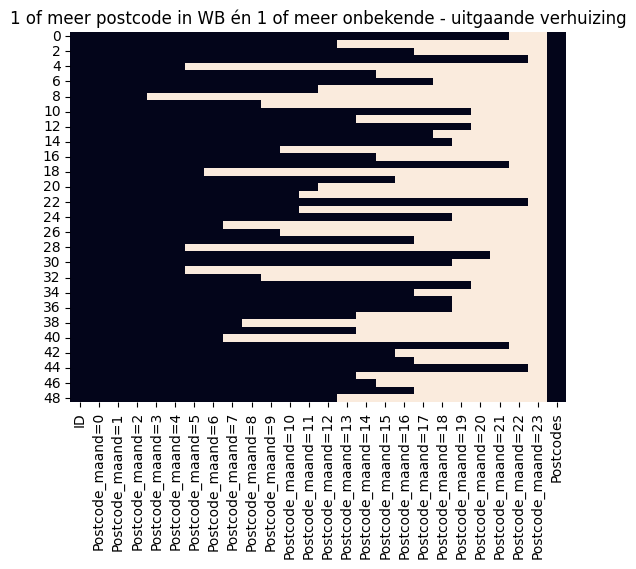

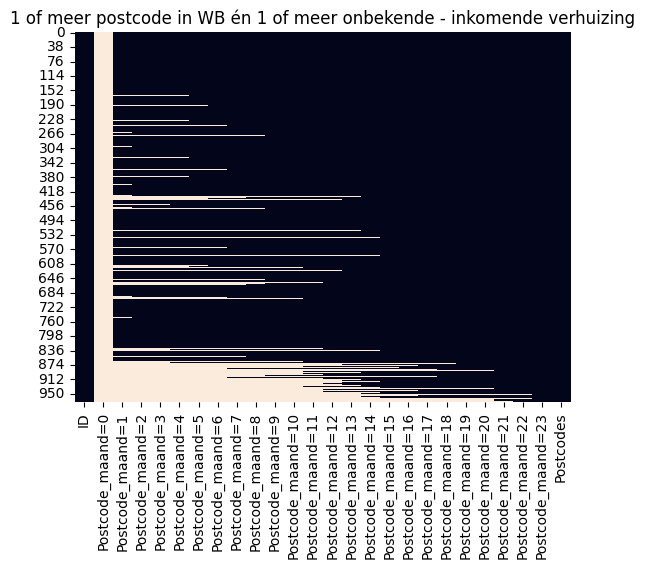

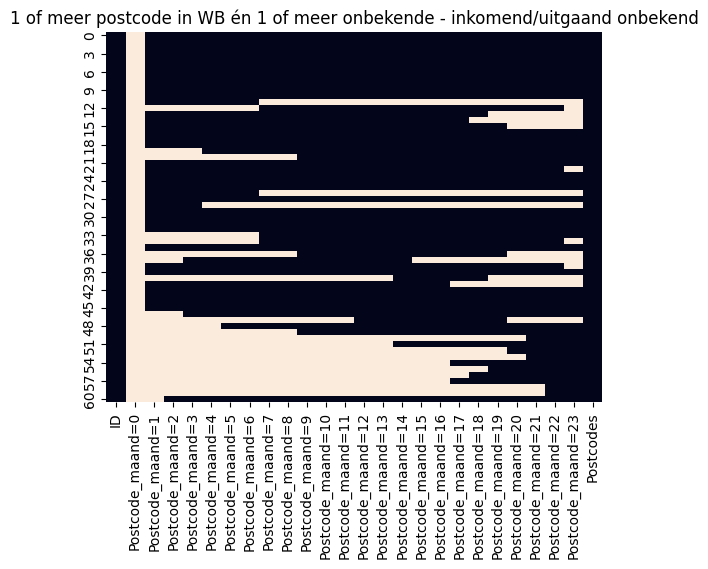

In [73]:
# Make subset
unknowns_out = clients_regions[clients_regions['Postcodes'].isin(['Deels onbekend - uitgaande verhuizing (includeren)', 'Deels onbekend - uitgaande verhuizing (excluderen)'])].reset_index(drop=True)
unknowns_out = unknowns_out.replace('Onbekend', np.NaN)
ax = plt.axes()
sns.heatmap(unknowns_out.isnull(), cbar=False)
ax.set_title(f'1 of meer postcode in WB én 1 of meer onbekende - uitgaande verhuizing')
plt.show()

# Make subset
unknowns_in = clients_regions[clients_regions['Postcodes'].isin(['Deels onbekend - inkomende verhuizing (includeren)', 'Deels onbekend - inkomende verhuizing (excluderen)'])].reset_index(drop=True)
unknowns_in = unknowns_in.replace('Onbekend', np.NaN)
ax = plt.axes()
sns.heatmap(unknowns_in.isnull(), cbar=False)
ax.set_title(f'1 of meer postcode in WB én 1 of meer onbekende - inkomende verhuizing')
plt.show()

# Make subset
unknowns_un = clients_regions[clients_regions['Postcodes'] == 'Deels onbekend - inkomend/uitgaand onbekend'].reset_index(drop=True)
unknowns_un = unknowns_un.replace('Onbekend', np.NaN)
ax = plt.axes()
sns.heatmap(unknowns_un.isnull(), cbar=False)
ax.set_title(f'1 of meer postcode in WB én 1 of meer onbekende - inkomend/uitgaand onbekend')
plt.show()

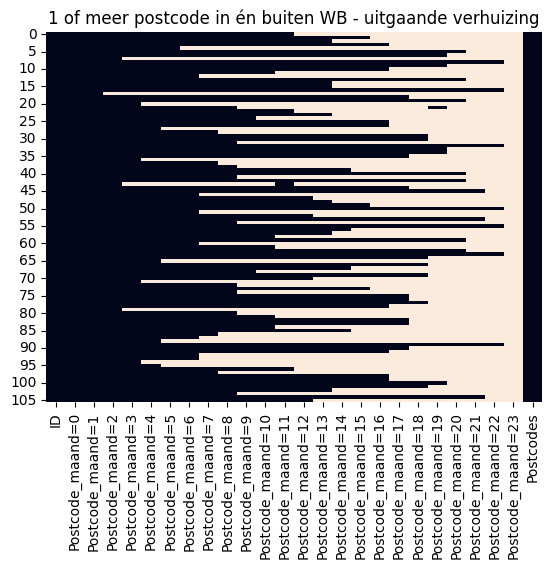

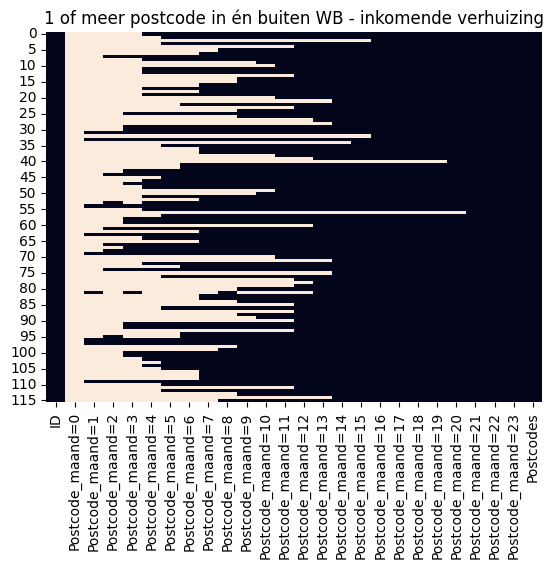

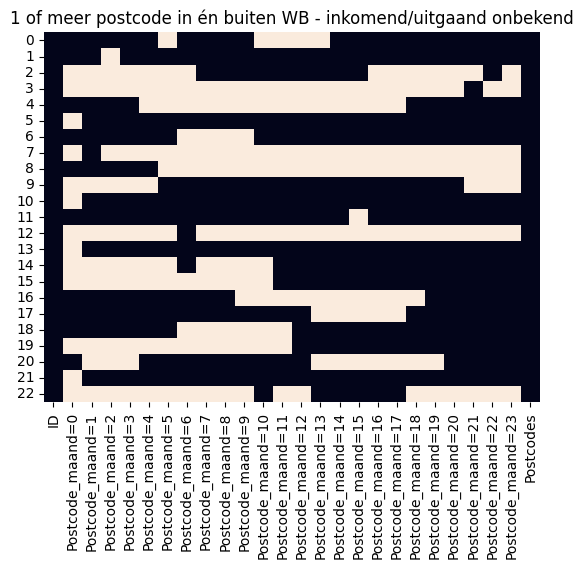

In [74]:
# Make subset
movers_out = clients_regions[clients_regions['Postcodes'].isin(['Deels buiten WB - uitgaande verhuizing (includeren)', 'Deels buiten WB - uitgaande verhuizing (excluderen)'])].reset_index(drop=True)
movers_out = movers_out.replace('Enkelvoudig - Buiten WB', np.NaN)
ax = plt.axes()
sns.heatmap(movers_out.isnull(), cbar=False)
ax.set_title(f'1 of meer postcode in én buiten WB - uitgaande verhuizing')
plt.show()

# Make subset
movers_in = clients_regions[clients_regions['Postcodes'].isin(['Deels buiten WB - inkomende verhuizing (includeren)', 'Deels buiten WB - inkomende verhuizing (excluderen)'])].reset_index(drop=True)
movers_in = movers_in.replace('Enkelvoudig - Buiten WB', np.NaN)
ax = plt.axes()
sns.heatmap(movers_in.isnull(), cbar=False)
ax.set_title(f'1 of meer postcode in én buiten WB - inkomende verhuizing')
plt.show()

# Make subset
movers_un = clients_regions[clients_regions['Postcodes'] == 'Deels buiten WB - inkomend/uitgaand onbekend'].reset_index(drop=True)
movers_un = movers_un.replace('Enkelvoudig - Buiten WB', np.NaN)
ax = plt.axes()
sns.heatmap(movers_un.isnull(), cbar=False)
ax.set_title(f'1 of meer postcode in én buiten WB - inkomend/uitgaand onbekend')
plt.show()

In [75]:
# Add the 'Postcodes' column to df_observaties, joining on 'Clientnummer'
df_observaties = df_observaties.merge(clients_regions[['ID', 'Postcodes']], on='ID', how='left')

In [76]:
# Fill missing values in 'Postcodes' with 'Niet gevonden'
df_observaties['Postcodes'] = df_observaties['Postcodes'].fillna('Volledig onbekende postcode')

In [77]:
df_observaties['Postcodes'].value_counts()

Postcodes
Volledig in WB                                         4581
Deels onbekend - inkomende verhuizing (includeren)      763
Deels onbekend - inkomende verhuizing (excluderen)      209
Onbekende postcode eerste 24 maanden                    116
Deels buiten WB - inkomende verhuizing (excluderen)     108
Deels buiten WB - uitgaande verhuizing (excluderen)      84
Deels onbekend - inkomend/uitgaand onbekend              61
Deels onbekend - uitgaande verhuizing (excluderen)       39
Volledig buiten WB                                       23
Deels buiten WB - inkomend/uitgaand onbekend             23
Deels buiten WB - uitgaande verhuizing (includeren)      22
Volledig in WB maar ook buiten WB                        19
Deels onbekend - uitgaande verhuizing (includeren)       10
Deels buiten WB - inkomende verhuizing (includeren)       8
Name: count, dtype: int64

In [78]:
df_observaties['Postcodes'].unique()

array(['Onbekende postcode eerste 24 maanden', 'Volledig in WB',
       'Deels onbekend - uitgaande verhuizing (includeren)',
       'Deels buiten WB - uitgaande verhuizing (excluderen)',
       'Volledig in WB maar ook buiten WB', 'Volledig buiten WB',
       'Deels buiten WB - inkomend/uitgaand onbekend',
       'Deels buiten WB - inkomende verhuizing (excluderen)',
       'Deels onbekend - uitgaande verhuizing (excluderen)',
       'Deels onbekend - inkomende verhuizing (includeren)',
       'Deels onbekend - inkomend/uitgaand onbekend',
       'Deels buiten WB - uitgaande verhuizing (includeren)',
       'Deels onbekend - inkomende verhuizing (excluderen)',
       'Deels buiten WB - inkomende verhuizing (includeren)'],
      dtype=object)

#### 4.3 Exclude classifications

In [79]:
# Specify which classes to preserve
classes_to_include = [
    # 'Onbekende postcode eerste 24 maanden',
    'Volledig in WB',
    'Deels onbekend - uitgaande verhuizing (includeren)',
    # 'Deels buiten WB - uitgaande verhuizing (excluderen)',
    # 'Volledig in WB maar ook buiten WB',
    # 'Volledig buiten WB',
    # 'Deels buiten WB - inkomend/uitgaand onbekend',
    # 'Deels buiten WB - inkomende verhuizing (excluderen)',
    # 'Deels onbekend - uitgaande verhuizing (excluderen)',
    'Deels onbekend - inkomende verhuizing (includeren)',
    # 'Deels onbekend - inkomend/uitgaand onbekend',
    'Deels buiten WB - uitgaande verhuizing (includeren)',
    # 'Deels onbekend - inkomende verhuizing (excluderen)',
    'Deels buiten WB - inkomende verhuizing (includeren)']

# Filter the df
df_observaties = df_observaties[df_observaties['Postcodes'].isin(classes_to_include)]

In [80]:
# Show head
print(df_observaties.shape)
df_observaties.head()

(5384, 19)


,Clientnummer,B.M.R.,DKTP,DTP,Hib,Pneu,Excluded,Hepatitis_B,MenACWY/MenC,Geboortejaarmaand,Tweeling,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland,Huisnummer_BRP,Postcode6_BRP,ID,Postcodes
27,8161527,1,3,0,3,3,0,3,1,2020-01,False,1980-12,39.0,Mannelijk,Nederland,19,4851AS,8161527,Volledig in WB
28,8163825,1,4,0,4,3,0,4,1,2020-01,False,1989-06,30.0,Vrouwelijk,Nederland,4,4904AR,8163825,Volledig in WB
29,8163828,0,3,0,3,2,0,3,0,2020-01,False,1990-02,29.0,Mannelijk,Nederland,3,4283HZ,8163828,Volledig in WB
30,8163856,1,4,0,4,4,0,4,1,2020-01,False,1982-12,37.0,Vrouwelijk,Nederland,5,4921DG,8163856,Volledig in WB
31,8163887,1,3,0,3,3,0,3,1,2020-01,False,1982-12,37.0,Vrouwelijk,Nederland,18,4841LD,8163887,Volledig in WB


#### 4.4 'Choose' PC6 and merge on df_observaties by 'ID'

In [81]:
# For every 'ID' in clients_addresses, randomly select a 'Postcode' from the 'Postcode' columns if it is not 'Onbekend'
for index, client in clients_addresses.iterrows():
    unique_postcodes_in = []
    for postcodes in postcode_columns:
        split_postcodes = client[postcodes].replace(' ', '').split(',')
        if len(split_postcodes) > 1:
            # Select the first one that is not 'Onbekend', is in pc4_to_include and not in pc6_to_exclude
            for postcode in split_postcodes:
                if postcode != 'Onbekend' and postcode[:4] in pc4_to_include and postcode not in pc6_to_exclude:
                    unique_postcodes_in.append(postcode)
        else:
            if split_postcodes[0] != 'Onbekend' and split_postcodes[0][:4] in pc4_to_include and split_postcodes[0] not in pc6_to_exclude:
                unique_postcodes_in.append(split_postcodes[0])
    # Randomly select a postcode from unique_postcodes if it is not empty
    if unique_postcodes_in:
        # Select a random postcode and set is as df_observaties['PC6'] by 'ID'
        df_observaties.loc[df_observaties['ID'] == client['ID'], 'PC6'] = np.random.choice(unique_postcodes_in)
    else:
        df_observaties.loc[df_observaties['ID'] == client['ID'], 'PC6'] = 'Onbekend'

#### 4.5 Add CBS_Buurtcodes, CBS_Buurtnamen and PC4 with PC6's to df_observaties

In [82]:
# Import municipalities to a pandas df
df_cbs = pd.read_excel('4_Data/2b-GWB2023_PC6.xlsx')

# Select only buurtcolumns
df_cbs = df_cbs.drop(columns=['GemCode', 'GemNaam', 'WijkCode', 'Wijknaam', 'AantalAdressen'])

# Remove the first two characters of every value in BuurtCode
df_cbs['BuurtCode'] = df_cbs['BuurtCode'].apply(lambda x: x[2:] if x[:2] == 'BU' else x)

# Keep only first rows of each unique PC6
df_cbs = df_cbs.drop_duplicates(subset='PC6')

# Merge
df_observaties = df_observaties.merge(df_cbs, on='PC6', how='left')

# Cast columns
df_observaties = df_observaties.astype({'BuurtCode': 'category', 'Buurtnaam': 'category'})

In [83]:
df_observaties['Buurtnaam'].isna().sum()

0

In [84]:
df_observaties['BuurtCode'].isna().sum()

0

In [85]:
df_observaties[df_observaties['BuurtCode'].isna()]

,Clientnummer,B.M.R.,DKTP,DTP,Hib,Pneu,Excluded,Hepatitis_B,MenACWY/MenC,Geboortejaarmaand,Tweeling,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland,Huisnummer_BRP,Postcode6_BRP,ID,Postcodes,PC6,BuurtCode,Buurtnaam


In [86]:
df_observaties['PC4'] = df_observaties['PC6'].apply(lambda x: x[:4])

### 5. Add vaccination status

In [87]:
# Add status for each vaccination individually, assuming Zuigelingen
df_observaties['Zuigelingen_status_B.M.R.'] = df_observaties['B.M.R.'].apply(lambda x: 'Vaccinated' if x >= 1 else 'Not Vaccinated')
df_observaties['Zuigelingen_status_Pneu'] = df_observaties['Pneu'].apply(lambda x: 'Vaccinated' if x >= 3 else ('Partially Vaccinated' if x > 0 else 'Not Vaccinated'))
df_observaties['Zuigelingen_status_DKTP'] = df_observaties['DKTP'].apply(lambda x: 'Vaccinated' if x >= 3 else ('Partially Vaccinated' if x > 0 else 'Not Vaccinated'))
df_observaties['Zuigelingen_status_MenACWY/MenC'] = df_observaties['MenACWY/MenC'].apply(lambda x: 'Vaccinated' if x >= 1 else 'Not Vaccinated')
df_observaties['Zuigelingen_status_Hib'] = df_observaties['Hib'].apply(lambda x: 'Vaccinated' if x >= 3 else ('Partially Vaccinated' if x > 0 else 'Not Vaccinated'))
df_observaties['Zuigelingen_status_Hepatitis_B'] = df_observaties['Hepatitis_B'].apply(lambda x: 'Vaccinated' if x >= 3 else ('Partially Vaccinated' if x > 0 else 'Not Vaccinated'))

# Add overall status for Zuigelingen and Schoolgaanden
df_observaties['Zuigelingen_status'] = df_observaties[['Zuigelingen_status_B.M.R.',
                                                       'Zuigelingen_status_Pneu',
                                                       'Zuigelingen_status_DKTP',
                                                       'Zuigelingen_status_MenACWY/MenC',
                                                       'Zuigelingen_status_Hib',
                                                       'Zuigelingen_status_Hepatitis_B']].apply(lambda x: 'Vaccinated' if 'Not Vaccinated' not in x.values and 'Partially Vaccinated' not in x.values else 'Not Vaccinated', axis=1)

# When a client is vaccinated for one or more vaccinations, but not all, they are considered partially vaccinated
condition_zuigelingen = ((df_observaties['B.M.R.'] > 0) | 
                         (df_observaties['Pneu'] > 0) | 
                         (df_observaties['DKTP'] > 0) | 
                         (df_observaties['MenACWY/MenC'] > 0) | 
                         (df_observaties['Hib'] > 0) | 
                         (df_observaties['Hepatitis_B'] > 0)) & (df_observaties['Zuigelingen_status'] != 'Vaccinated')

# Assign 'Partially vaccinated' where conditions are True
df_observaties.loc[condition_zuigelingen, 'Zuigelingen_status'] = 'Partially vaccinated'

In [88]:
# Show head
print(df_observaties.shape)
df_observaties.head()

(5384, 30)


,Clientnummer,B.M.R.,DKTP,DTP,Hib,Pneu,Excluded,Hepatitis_B,MenACWY/MenC,Geboortejaarmaand,Tweeling,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland,Huisnummer_BRP,Postcode6_BRP,ID,Postcodes,PC6,BuurtCode,Buurtnaam,PC4,Zuigelingen_status_B.M.R.,Zuigelingen_status_Pneu,Zuigelingen_status_DKTP,Zuigelingen_status_MenACWY/MenC,Zuigelingen_status_Hib,Zuigelingen_status_Hepatitis_B,Zuigelingen_status
0,8161527,1,3,0,3,3,0,3,1,2020-01,False,1980-12,39.0,Mannelijk,Nederland,19,4851AS,8161527,Volledig in WB,4851AS,07580800,Ulvenhout,4851,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated
1,8163825,1,4,0,4,3,0,4,1,2020-01,False,1989-06,30.0,Vrouwelijk,Nederland,4,4904AR,8163825,Volledig in WB,4904AR,08260505,Paterserf,4904,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated
2,8163828,0,3,0,3,2,0,3,0,2020-01,False,1990-02,29.0,Mannelijk,Nederland,3,4283HZ,8163828,Volledig in WB,4283HZ,19591001,Giessen,4283,Not Vaccinated,Partially Vaccinated,Vaccinated,Not Vaccinated,Vaccinated,Vaccinated,Partially vaccinated
3,8163856,1,4,0,4,4,0,4,1,2020-01,False,1982-12,37.0,Vrouwelijk,Nederland,5,4921DG,8163856,Volledig in WB,4921DG,17190207,Stuivezand,4921,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated
4,8163887,1,3,0,3,3,0,3,1,2020-01,False,1982-12,37.0,Vrouwelijk,Nederland,18,4841LD,8163887,Volledig in WB,4841NS,07580900,Prinsenbeek,4841,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated,Vaccinated


<Axes: xlabel='Postcodes'>

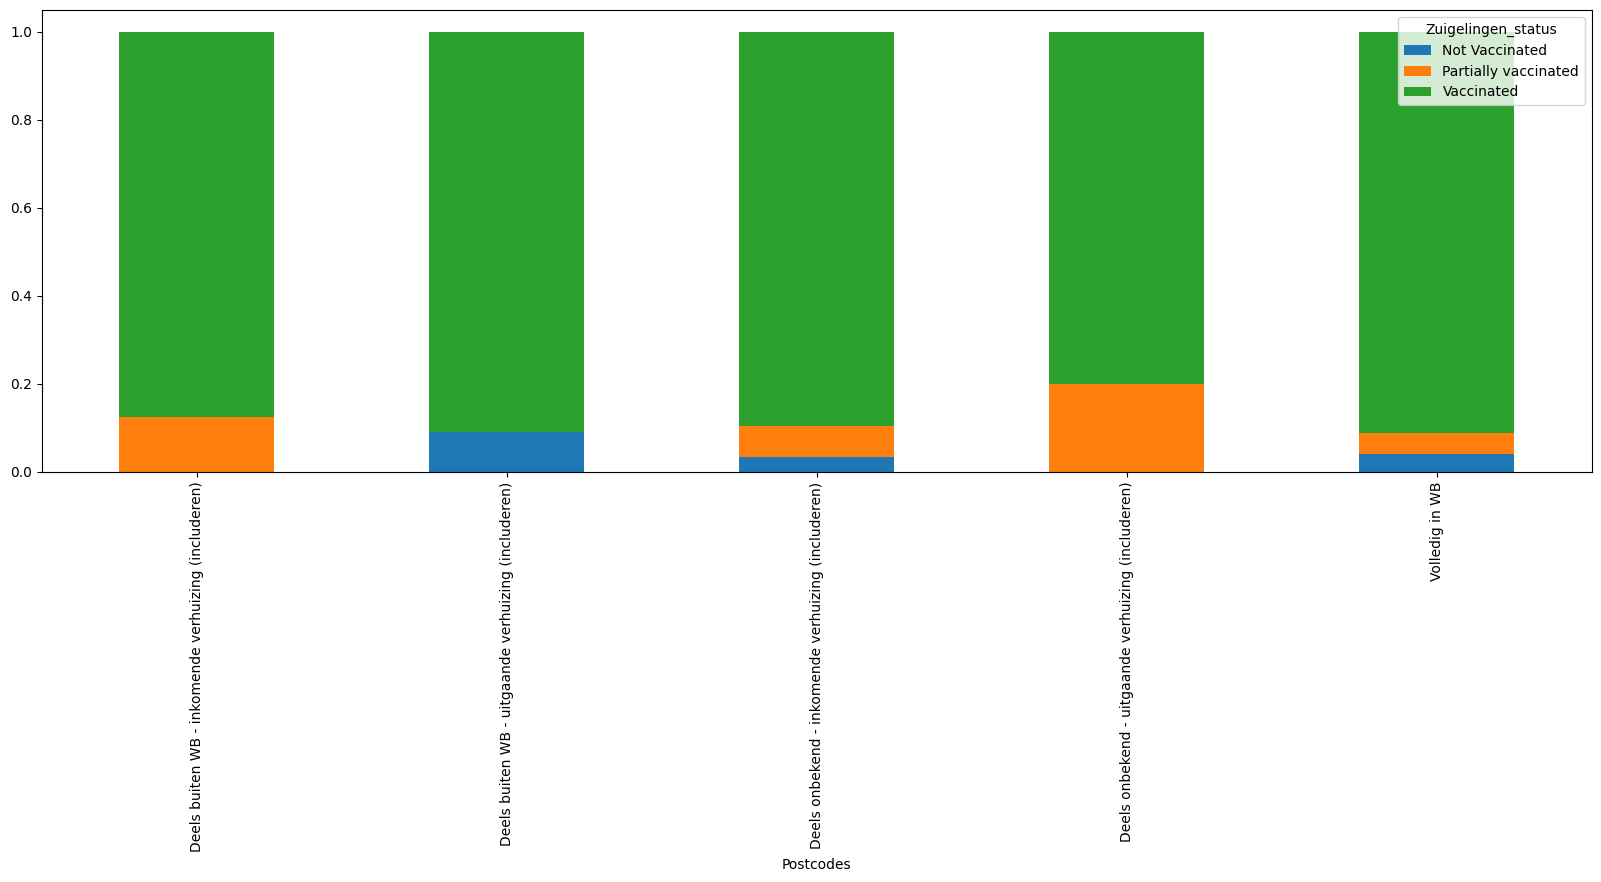

In [89]:
# Group df_observaties by 'Postcodes' and show the percentages of 'Zuigelingen_status' for each group
df_observaties.groupby('Postcodes')['Zuigelingen_status'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(20, 6))

### 6. Show results

In [90]:
# Calculate the percentages of zuigelingen
zuigelingen_rates = df_observaties['Zuigelingen_status'].value_counts(normalize=True)
print(zuigelingen_rates)

Zuigelingen_status
Vaccinated              0.909918
Partially vaccinated    0.049591
Not Vaccinated          0.040490
Name: proportion, dtype: float64


In [91]:
# Store yearmonths for subcategories
cohort_2020 = pd.to_datetime(['202001', '202002', '202003', '202004', '202005', '202006', '202007', '202008', '202009', '202010', '202011', '202012'], format='%Y%m').to_period('M')
cohort_2021 = pd.to_datetime(['202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108', '202109', '202110', '202111', '202112'], format='%Y%m').to_period('M')

# Calculate the percentages of Zuigelingen for each status
zuigelingen_2020 = df_observaties[df_observaties['Geboortejaarmaand'].isin(cohort_2020)]
zuigelingen_2020_rates = zuigelingen_2020['Zuigelingen_status'].value_counts(normalize=True)

# Calculate the percentages of Zuigelingen for each status
zuigelingen_2021 = df_observaties[df_observaties['Geboortejaarmaand'].isin(cohort_2021)]
zuigelingen_2021_rates = zuigelingen_2021['Zuigelingen_status'].value_counts(normalize=True)

# Print statusses per cohort
print('2020')
print(zuigelingen_2020_rates)
print('-'*20)
print('2021')
print(zuigelingen_2021_rates)

2020
Zuigelingen_status
Vaccinated              0.912583
Partially vaccinated    0.047432
Not Vaccinated          0.039984
Name: proportion, dtype: float64
--------------------
2021
Zuigelingen_status
Vaccinated              0.907519
Partially vaccinated    0.051535
Not Vaccinated          0.040946
Name: proportion, dtype: float64


In [92]:
# Calculate the percentages of Schoolgaanden for each status
zuigelingen_2020 = df_observaties[df_observaties['Geboortejaarmaand'].isin(cohort_2020)]
zuigelingen_2020_rates_BMR = zuigelingen_2020['Zuigelingen_status_B.M.R.'].value_counts(normalize=True)
zuigelingen_2020_rates_Pneu = zuigelingen_2020['Zuigelingen_status_Pneu'].value_counts(normalize=True)
zuigelingen_2020_rates_DKTP = zuigelingen_2020['Zuigelingen_status_DKTP'].value_counts(normalize=True)
zuigelingen_2020_rates_MenACWYMenC = zuigelingen_2020['Zuigelingen_status_MenACWY/MenC'].value_counts(normalize=True)
zuigelingen_2020_rates_Hib = zuigelingen_2020['Zuigelingen_status_Hib'].value_counts(normalize=True)
zuigelingen_2020_rates_Hepatitis_B = zuigelingen_2020['Zuigelingen_status_Hepatitis_B'].value_counts(normalize=True)

# Calculate the percentages of Schoolgaanden for each status
zuigelingen_2021 = df_observaties[df_observaties['Geboortejaarmaand'].isin(cohort_2021)]
zuigelingen_2021_rates_BMR = zuigelingen_2021['Zuigelingen_status_B.M.R.'].value_counts(normalize=True)
zuigelingen_2021_rates_Pneu = zuigelingen_2021['Zuigelingen_status_Pneu'].value_counts(normalize=True)
zuigelingen_2021_rates_DKTP = zuigelingen_2021['Zuigelingen_status_DKTP'].value_counts(normalize=True)
zuigelingen_2021_rates_MenACWYMenC = zuigelingen_2021['Zuigelingen_status_MenACWY/MenC'].value_counts(normalize=True)
zuigelingen_2021_rates_Hib = zuigelingen_2021['Zuigelingen_status_Hib'].value_counts(normalize=True)
zuigelingen_2021_rates_Hepatitis_B = zuigelingen_2021['Zuigelingen_status_Hepatitis_B'].value_counts(normalize=True)

# Print statusses]
print('Zuigelingen 2020')
print('\n')
print(zuigelingen_2020_rates_BMR)
print('\n')
print(zuigelingen_2020_rates_Pneu)
print('\n')
print(zuigelingen_2020_rates_DKTP)
print('\n')
print(zuigelingen_2020_rates_MenACWYMenC)
print('\n')
print(zuigelingen_2020_rates_Hib)
print('\n')
print(zuigelingen_2020_rates_Hepatitis_B)
print('-'*20)
print('Zuigelingen 2021')
print('\n')
print(zuigelingen_2021_rates_BMR)
print('\n')
print(zuigelingen_2021_rates_Pneu)
print('\n')
print(zuigelingen_2021_rates_DKTP)
print('\n')
print(zuigelingen_2021_rates_MenACWYMenC)
print('\n')
print(zuigelingen_2021_rates_Hib)
print('\n')
print(zuigelingen_2021_rates_Hepatitis_B)

Zuigelingen 2020


Zuigelingen_status_B.M.R.
Vaccinated        0.935711
Not Vaccinated    0.064289
Name: proportion, dtype: float64


Zuigelingen_status_Pneu
Vaccinated              0.924343
Not Vaccinated          0.044688
Partially Vaccinated    0.030968
Name: proportion, dtype: float64


Zuigelingen_status_DKTP
Vaccinated              0.938064
Not Vaccinated          0.040768
Partially Vaccinated    0.021168
Name: proportion, dtype: float64


Zuigelingen_status_MenACWY/MenC
Vaccinated        0.932967
Not Vaccinated    0.067033
Name: proportion, dtype: float64


Zuigelingen_status_Hib
Vaccinated              0.938064
Not Vaccinated          0.040768
Partially Vaccinated    0.021168
Name: proportion, dtype: float64


Zuigelingen_status_Hepatitis_B
Vaccinated              0.938064
Not Vaccinated          0.040768
Partially Vaccinated    0.021168
Name: proportion, dtype: float64
--------------------
Zuigelingen 2021


Zuigelingen_status_B.M.R.
Vaccinated        0.929756
Not Vaccinated  

In [93]:
# Define a list of all the variables
variables_zuigelingen = [zuigelingen_2020_rates_BMR, zuigelingen_2021_rates_BMR, zuigelingen_2020_rates_Pneu, zuigelingen_2021_rates_Pneu, zuigelingen_2020_rates_DKTP, zuigelingen_2021_rates_DKTP,
                         zuigelingen_2020_rates_MenACWYMenC, zuigelingen_2021_rates_MenACWYMenC, zuigelingen_2020_rates_Hib, zuigelingen_2021_rates_Hib, zuigelingen_2020_rates_Hepatitis_B, zuigelingen_2021_rates_Hepatitis_B]

# Store the vaccinated percentages
vaccinated_zuigelingen = [variable['Vaccinated']*100 for variable in variables_zuigelingen]

# Define a list of the variable names for 'Zuigelingen'
variable_names_zuigelingen = ['BMR 2020', 'BMR 2021', 'Pneu 2020', 'Pneu 2021', 'DKTP 2020', 'DKTP 2021', 'MenACWY/MenC 2020', 'MenACWY/MenC 2021',
                              'Hib 2020', 'Hib 2021', 'Hepatitis_B 2020', 'Hepatitis_B 2021']

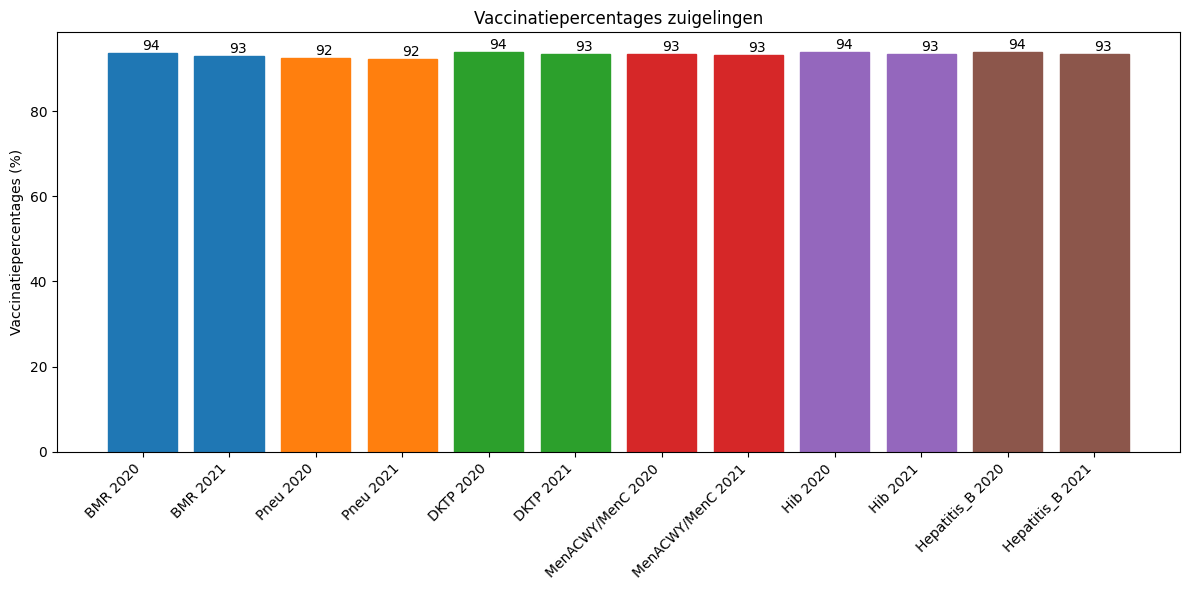

In [94]:
# Create a figure with 1 subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot the vaccinated percentages
bars = ax.bar(variable_names_zuigelingen, vaccinated_zuigelingen)

# Initialize color palette and counters
color = sns.color_palette()
color_nr = 0
iteration_nr = -1

# Annotate bars with the percentage values and set colors
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval), va='bottom')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Set colors for bars
    bar.set_color(color[color_nr])
    if iteration_nr % 2 == 0:
        color_nr += 1
    iteration_nr += 1

# Add title and y-axis label
ax.set_title('Vaccinatiepercentages zuigelingen')
ax.set_ylabel('Vaccinatiepercentages (%)')

# Show the plot
plt.tight_layout()
plt.savefig('9_Results/Zuigelingen/Vaccinatiepercentages_zuigelingen.jpg', dpi=300)
plt.show()

## 7. Visualize geographically

In [95]:
# From df_observaties calculate the percentages of 'Zuigelingen_status' per unique CBS_Buurtcode_BRP
buurt_percentages = df_observaties.groupby('BuurtCode')['Zuigelingen_status'].value_counts(normalize=True).unstack().fillna(0)

# Reset index
buurt_percentages = buurt_percentages.reset_index()

In [96]:
# Reading GeoPackage file
cbs_df = gpd.read_file('4_Data/Polygons/buurten_2023_v1.shp')

# Replace every -99997 with NaN
cbs_df = cbs_df.replace(-99997, np.nan)

# From every row in 'BU_CODE' remove the first two characters
cbs_df['BU_CODE'] = cbs_df['BU_CODE'].astype(str).str[2:]

# Filter the df_pc4 to only include the relevant municipalities
cbs_df = cbs_df[cbs_df['GM_NAAM'].isin(municipalities)]

In [97]:
# Merge polygons with percentages
gdf = cbs_df.merge(buurt_percentages[['BuurtCode', 'Vaccinated']], left_on='BU_CODE', right_on='BuurtCode', how='left')

# Change proportions in percentages and round to integers
gdf['Vaccinated'] = (gdf['Vaccinated']*100).round(0)

# Dissolve neighborhoods into municipalities
municipalities_gdf = gdf.dissolve(by='GM_NAAM')

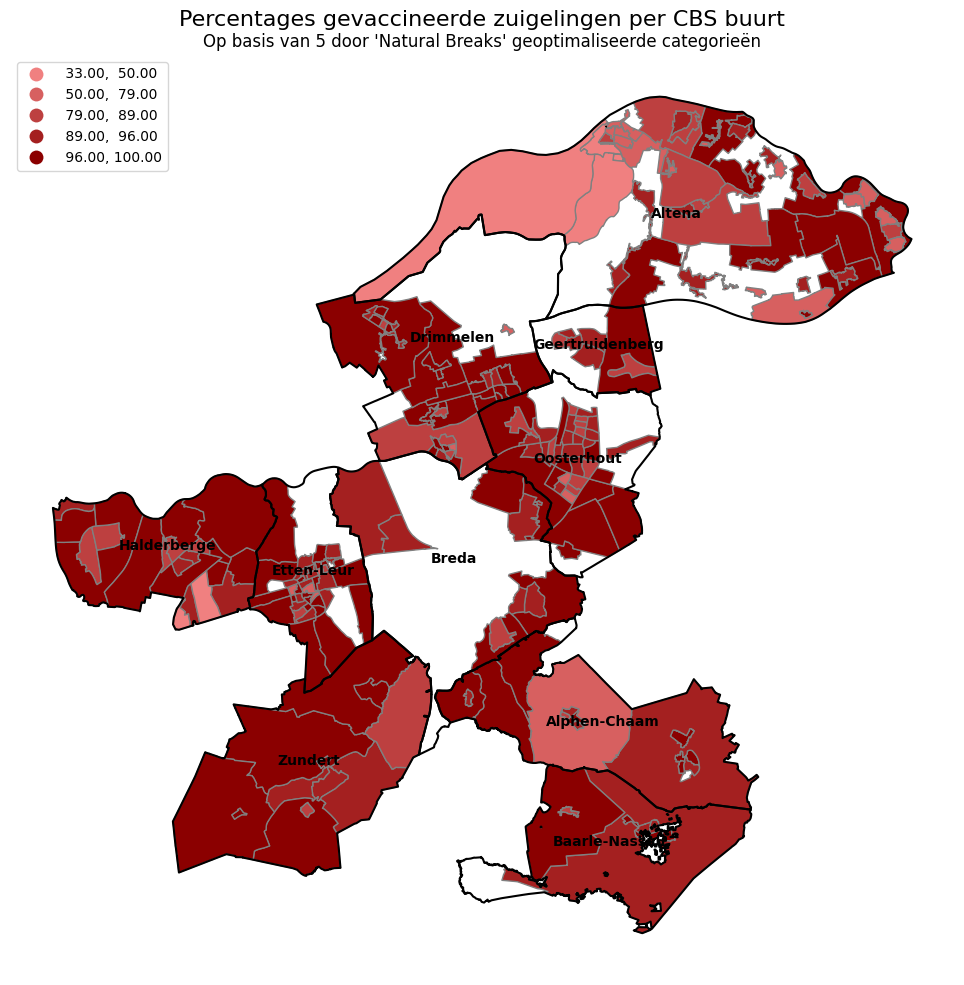

In [98]:
# Create a unidirectional colormap (e.g., from light to dark red)
cmap = mcolors.LinearSegmentedColormap.from_list('unidirectional', ['lightcoral', 'darkred'])

# Create a figure and axis with a grey background
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot neighborhood-level data
gdf.plot(column='Vaccinated',
         cmap=cmap,
         scheme='NaturalBreaks',
         k=5,
         legend=True,
         ax=ax,
         edgecolor='grey',  # Grey edge color for neighborhoods
         legend_kwds={'loc': 'upper left'})

# Overlay municipality boundaries with black edges
municipalities_gdf.boundary.plot(ax=ax, edgecolor='black')

# Plot municipality names
for idx, row in municipalities_gdf.iterrows():
    plt.annotate(text=row.name, xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=10, fontweight='bold', color='black')

# Remove axis
ax.set_axis_off()

# Add title
plt.suptitle('Percentages gevaccineerde zuigelingen per CBS buurt', fontsize=16)
plt.title('Op basis van 5 door \'Natural Breaks\' geoptimaliseerde categorieën')
plt.tight_layout()
plt.savefig('9_Results/Zuigelingen/Vaccinatiepercentages_zuigelingen_buurten.jpg', dpi=300)
plt.show()

In [99]:
# Rename BU_CODE to CBS_Buurtcode_BRP in cbs_df
cbs_df = cbs_df.rename(columns={'BU_CODE': 'BuurtCode'})

# Add the GM_NAAM to the df_observaties by merging on 'CBS_Buurtcode_BRP'
df_observaties_gem = df_observaties.merge(cbs_df[['BuurtCode', 'GM_NAAM']], on='BuurtCode', how='left')

In [100]:
# Split cohorts
df_observaties_gem_2020 = df_observaties_gem[df_observaties_gem['Geboortejaarmaand'].isin(cohort_2020)]
df_observaties_gem_2021 = df_observaties_gem[df_observaties_gem['Geboortejaarmaand'].isin(cohort_2021)]

In [101]:
# From df_observaties calculate the percentages of 'Zuigelingen_status' per unique CBS_Buurtcode_BRP
gem_2020_percentages = df_observaties_gem_2020.groupby('GM_NAAM')['Zuigelingen_status'].value_counts(normalize=True).unstack().fillna(0)
gem_2021_percentages = df_observaties_gem_2021.groupby('GM_NAAM')['Zuigelingen_status'].value_counts(normalize=True).unstack().fillna(0)

# Reset index
gem_2020_percentages = gem_2020_percentages.reset_index()[['GM_NAAM', 'Vaccinated']]
gem_2021_percentages = gem_2021_percentages.reset_index()[['GM_NAAM', 'Vaccinated']]

# Dissolve neighborhoods into municipalities
cbs_df = cbs_df.dissolve(by='GM_NAAM')
cbs_df.reset_index(inplace=True)

# Add geometry to gem_percentages by merging on 'GM_NAAM' with cbs_df
gem_2020_percentages = cbs_df.merge(gem_2020_percentages[['GM_NAAM', 'Vaccinated']], on='GM_NAAM', how='left')
gem_2021_percentages = cbs_df.merge(gem_2021_percentages[['GM_NAAM', 'Vaccinated']], on='GM_NAAM', how='left')

# Ensure the 'Vaccinated' column contains only numeric values
gem_2020_percentages['Vaccinated'] = pd.to_numeric(gem_2020_percentages['Vaccinated'])
gem_2021_percentages['Vaccinated'] = pd.to_numeric(gem_2021_percentages['Vaccinated'])

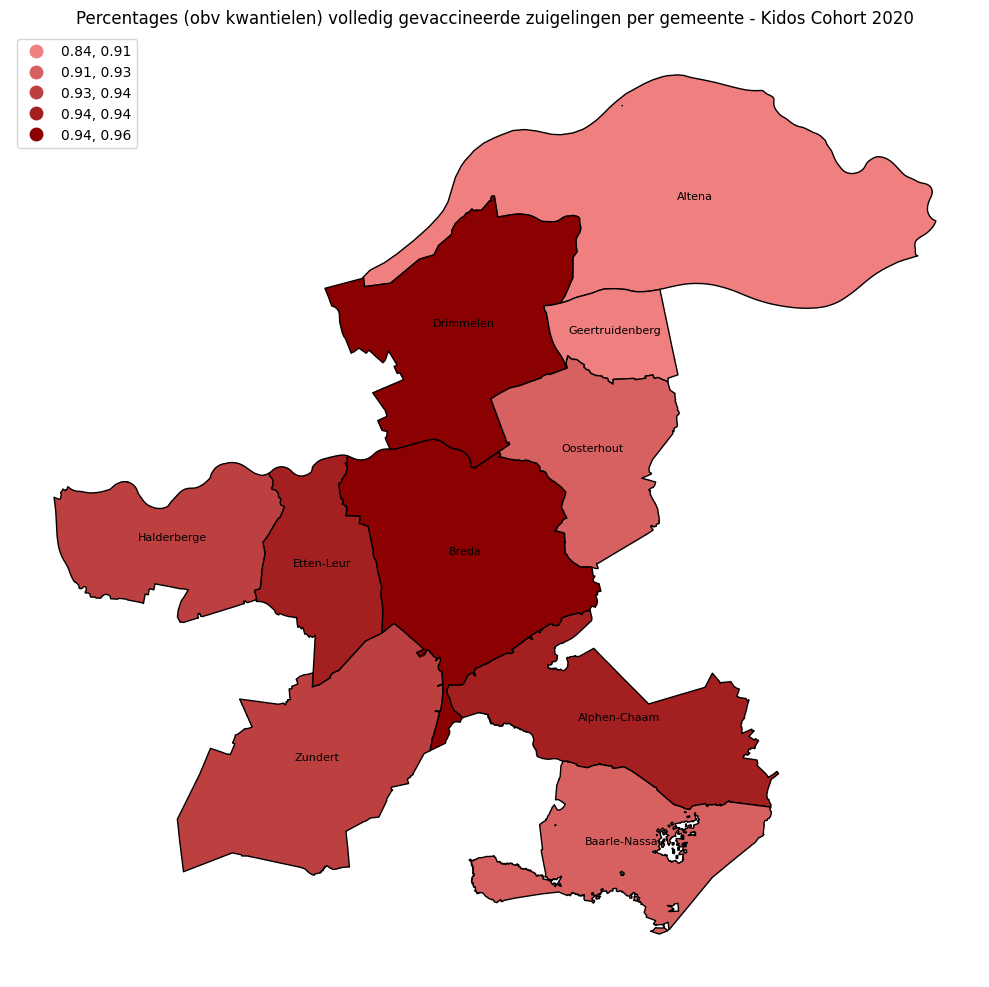

In [102]:
# Create a figure and axis with a grey background
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot neighborhood-level data
gem_2020_percentages.plot(column='Vaccinated',
                          cmap=cmap,
                          scheme='quantiles',
                          k=5,
                          legend=True,
                          ax=ax,
                          edgecolor='black',
                          legend_kwds={'loc': 'upper left'})

# Plot municipality names
for idx, row in municipalities_gdf.iterrows():
    plt.annotate(text=row.name, xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')

# Remove axis
ax.set_axis_off()

# Add title
plt.title('Percentages (obv kwantielen) volledig gevaccineerde zuigelingen per gemeente - Kidos Cohort 2020')
plt.tight_layout()
plt.savefig('9_Results/Zuigelingen/Vaccinatiepercentages_zuigelingen_gemeenten_kidos2020.jpg', dpi=300)
plt.show()

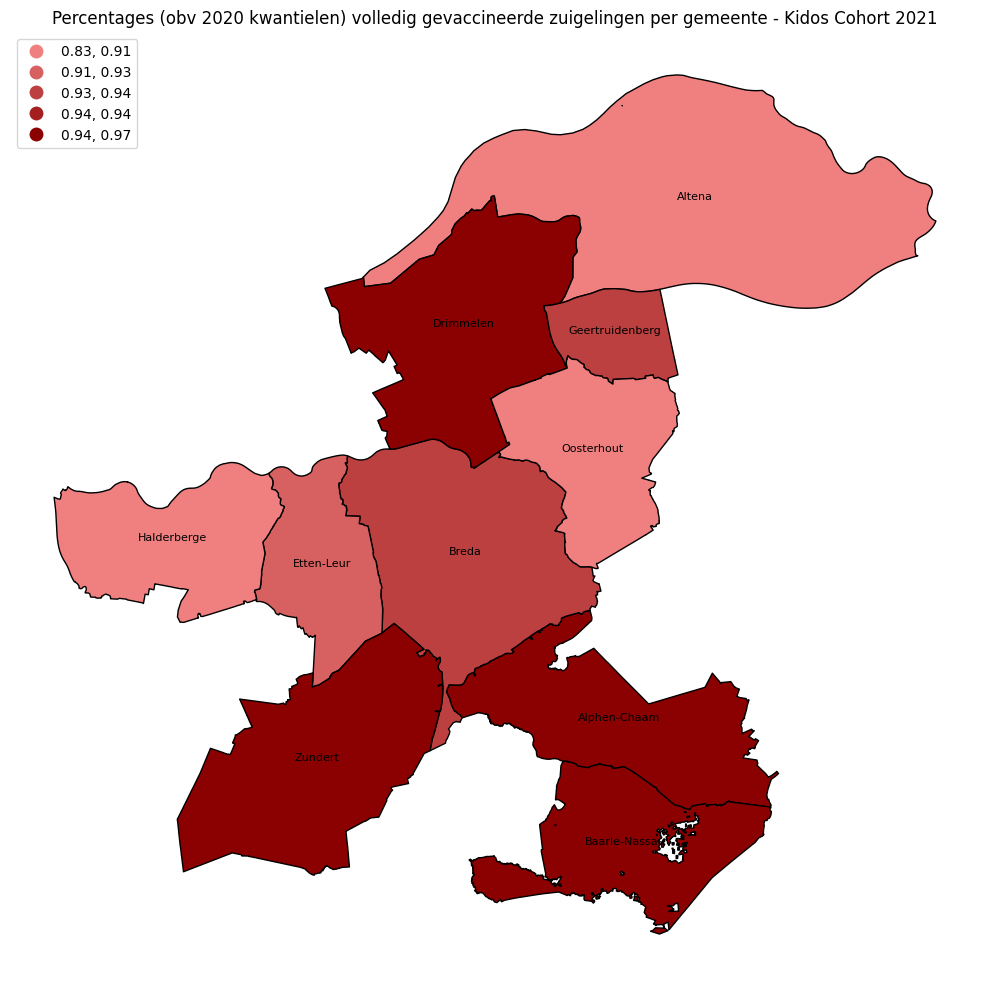

In [103]:
# Get 2020 quantiles
custom_quantiles = gem_2020_percentages['Vaccinated'].quantile([0.2, 0.4, 0.6, 0.8]).values

# Create a figure and axis with a grey background
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot neighborhood-level data
gem_2021_percentages.plot(column='Vaccinated',
                          cmap=cmap,
                          scheme='user_defined',
                          classification_kwds={'bins': custom_quantiles},
                          legend=True,
                          ax=ax,
                          edgecolor='black',
                          legend_kwds={'loc': 'upper left'})

# Plot municipality names
for idx, row in municipalities_gdf.iterrows():
    plt.annotate(text=row.name, xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')

# Remove axis
ax.set_axis_off()

# Add title
plt.title('Percentages (obv 2020 kwantielen) volledig gevaccineerde zuigelingen per gemeente - Kidos Cohort 2021')
plt.tight_layout()
plt.savefig('9_Results/Zuigelingen/Vaccinatiepercentages_zuigelingen_gemeenten_kidos2021.jpg', dpi=300)
plt.show()

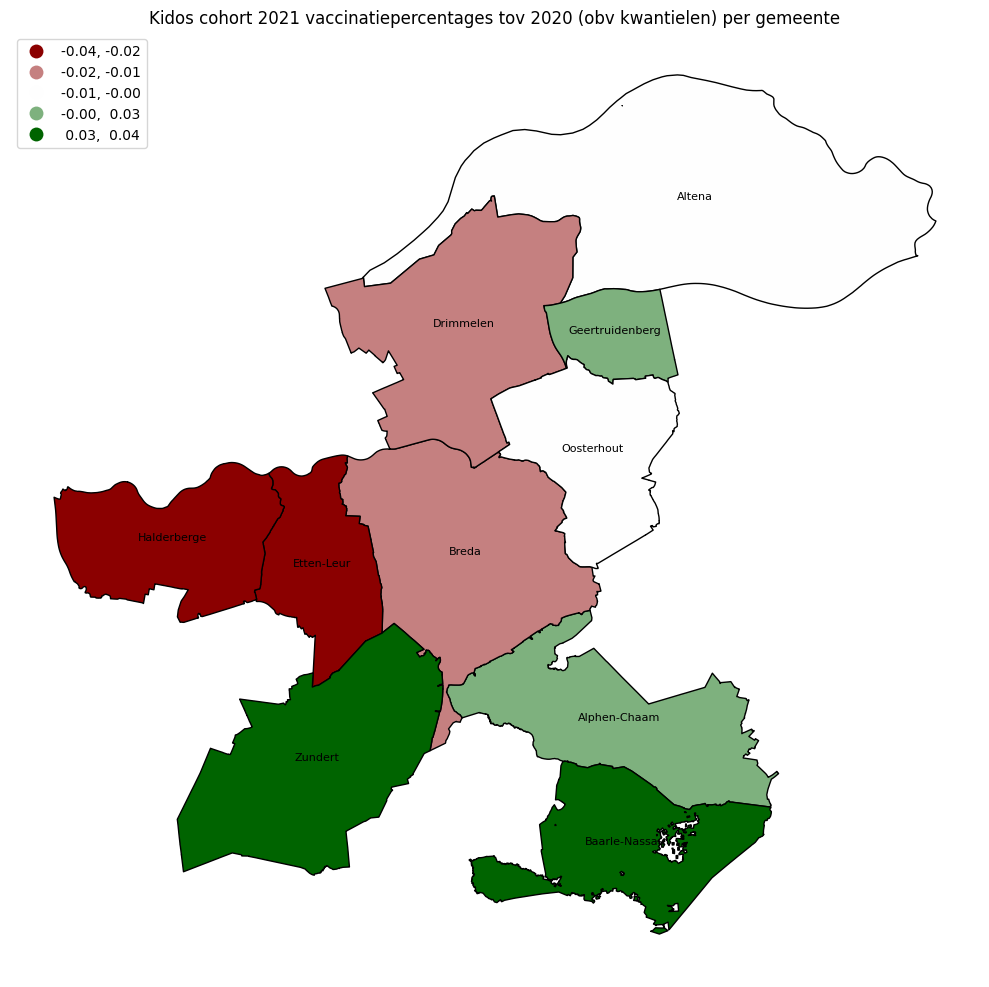

In [104]:
# Save increase or decrease in percentages
gem_2020_percentages['Diff'] = gem_2021_percentages['Vaccinated'] - gem_2020_percentages['Vaccinated']

# Create a custom diverging colormap
cmap = mcolors.LinearSegmentedColormap.from_list('custom_diverging', ['darkred', 'white', 'darkgreen'])

# Create a figure and axis with a grey background
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot neighborhood-level data with the custom diverging colormap
gem_2020_percentages.plot(column='Diff',
                          cmap=cmap,
                          scheme='quantiles',
                          k=5,
                          legend=True,
                          ax=ax,
                          edgecolor='black',
                          legend_kwds={'loc': 'upper left'})

# Plot municipality names
for idx, row in gem_2020_percentages.iterrows():
    plt.annotate(text=row.GM_NAAM, xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')

# Remove axis
ax.set_axis_off()

# Add title
plt.title('Kidos cohort 2021 vaccinatiepercentages tov 2020 (obv kwantielen) per gemeente')
plt.tight_layout()
plt.savefig('9_Results/Zuigelingen/Vaccinatiepercentages_zuigelingen_gemeenten_kidosverschil.jpg', dpi=300)
plt.show()

## 8. Save as .pkl

In [105]:
# Save df_observaties as .pkl file
df_observaties.to_pickle('4_Data/Pickles/zuigelingen_observaties.pkl')